In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys

In [2]:
results_frame = dict()
samples = os.listdir("METs")
for s in samples:
    if ("SH" in s) | ("merged" in s) & ("failed" not in s) & ("2" not in s):
        results_frame[s] = pd.read_csv(os.path.join("METs",s), sep = "\t", index_col=0)

/vortexfs1/home/akrinos/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
summarized_frame = dict()
for curr in results_frame.keys():
    results_frame[curr]["count_by"] = 1
    mean_results = results_frame[curr].groupby("classification_level").max_pid.mean().reset_index()
    sum_results = results_frame[curr].groupby("classification_level").sum().reset_index()
    sum_results["max_pid"] = mean_results["max_pid"]
    summarized_frame[curr] = sum_results
    
summarized_frame[curr]

,classification_level,max_pid,ambiguous,count_by
0,class,42.397711,908,97958
1,family,72.201150,5120,187231
2,genus,87.025014,6671,144140
3,order,57.743812,2442,178373
4,species,97.882516,6722,51888


In [6]:
diel_dict = {"SH402":0,"SH487":4,"SH488":8,"SH489":12,"SH490":16,"SH491":20,"SH492":24,"SH493":28,"merged":-1}
counter = 0
for curr in summarized_frame.keys():
    curr_frame = summarized_frame[curr]
    curr_frame["Sample"] = curr.split(".")[len(curr.split(".")) - 2].split("-")[0]                              
    print(curr.split(".")[len(curr.split(".")) - 2].split("-")[0])
    #curr.split("_")[0].split("-")[0]
    curr_frame["Diel"] = diel_dict[curr.split("_")[0].split("-")[0]]
    if counter == 0:
        total_frame = curr_frame
    else:
        total_frame = pd.concat([total_frame,curr_frame],axis=0)
    counter = counter + 1

SH490_megahit
SH402_merged
merged
SH402_trinity
SH488_trinity
SH493_merged
SH402_megahit
SH493_megahit
SH491_trinity
SH493_trinity
SH489_merged
SH488_merged
SH489_trinity
SH490_merged
SH489_megahit
SH491_megahit
SH491_merged
SH488_megahit
SH492_megahit
SH492_trinity
SH487_megahit
SH487_merged
SH492_merged
SH487_trinity
SH490_trinity


In [7]:
#sns.barplot(x = "classification_level", y = "count_by", hue = "Diel", \
#            data=total_frame.loc[total_frame.Diel != -1])
currsample = [True if "SH490" in curr else False for curr in total_frame.Sample]
sns.barplot(x = "classification_level", y = "count_by", hue = "Diel", \
            data=total_frame.loc[(total_frame.Diel != -1) & currsample])

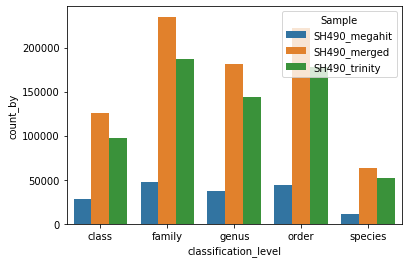

In [9]:
sns.barplot(x = "classification_level", y = "count_by", hue = "Sample", \
            data=total_frame.loc[(total_frame.Diel != -1) & currsample])

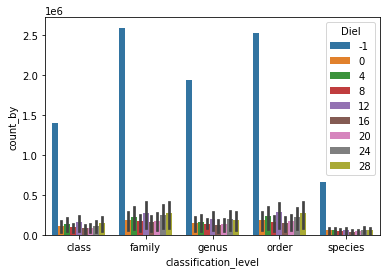

In [10]:
sns.barplot(x = "classification_level", y = "count_by", hue = "Diel", \
            data=total_frame)

In [11]:
class_frame = dict()
unique_species = dict()
unique_genus = dict()
unique_order = dict()

def stripGenus(df):
    genuses = set()
    full_class_spec = list(df.loc[list(df["classification"]) == "species"]["full_classification"])
    full_class_genus = list(df.loc[list(df["classification"]) == "genus"]["full_classification"])
    genuses.update([cr.split(";")[len(cr.split(";"))-1].strip() for cr in full_class_spec])
    genuses.update([cr.split(";")[len(cr.split(";"))-2].strip() for cr in full_class_genus])
    return genuses

def stripGenusAndOrder(df):
    orders = set()
    genuses = set()
    full_class_spec = list(df.loc[list(df["classification"]) == "species"]["full_classification"])
    full_class_genus = list(df.loc[list(df["classification"]) == "genus"]["full_classification"])
    full_class_order = list(df.loc[list(df["classification"]) == "order"]["full_classification"])
    species = [cr.split(";")[len(cr.split(";"))-1].strip() for cr in full_class_spec]
    genus = [cr.split(";")[len(cr.split(";"))-2].strip() for cr in full_class_genus]
    order = [cr.split(";")[len(cr.split(";"))-3].strip() for cr in full_class_order]
    
    # Add to orders set
    orders.update(genus)
    orders.update(species)
    orders.update(order)
    
    # Add to genus sets
    genusus.update(genus)
    genusus.update(species)
    return genuses, orders
    
# characterizing by major classes 
for curr in results_frame.keys():
    results_frame[curr]["Haptophytes"] = [1 if "Haptophyta" in curr else 0 \
                                          for curr in results_frame[curr]["full_classification"]]
    results_frame[curr]["Dinoflagellates"] = [1 if "Dinoflagellata" in curr else 0 \
                                          for curr in results_frame[curr]["full_classification"]]
    results_frame[curr]["Ochrophytes"] = [1 if "Ochrophyta" in curr else 0 \
                                          for curr in results_frame[curr]["full_classification"]]
    results_frame[curr]["Cryptophytes"] = [1 if "Cryptophyta" in curr else 0 \
                                          for curr in results_frame[curr]["full_classification"]]
    results_frame[curr]["Choanoflagellides"] = [1 if "Choanoflagellida" in curr else 0 \
                                          for curr in results_frame[curr]["full_classification"]]
    unique_species[curr] = set()
    full_class = list(results_frame[curr].loc[list(results_frame[curr]["classification"]) == "species"]["full_classification"])
    unique_species[curr].update([cr.split(";")[len(cr.split(";"))-1].strip() for cr in full_class])
    
    #unique_genus[curr] = stripGenus(results_frame[curr])
    unique_genus[curr], unique_order[curr] = stripGenusAndOrder(results_frame[curr])
    
    sum_results = pd.DataFrame({ "Class": ["Haptophytes","Dinoflagellates","Ochrophytes",\
                                           "Cryptophytes","Choanoflagellides"],
                            "count": [sum(results_frame[curr]["Haptophytes"]),\
                                  sum(results_frame[curr]["Dinoflagellates"]),\
                                  sum(results_frame[curr]["Ochrophytes"]),\
                                  sum(results_frame[curr]["Cryptophytes"]),\
                                  sum(results_frame[curr]["Choanoflagellides"])]})
    class_frame[curr] = sum_results

In [12]:
class_frame[curr]

,Class,count
0,Haptophytes,100373
1,Dinoflagellates,267261
2,Ochrophytes,128925
3,Cryptophytes,86586
4,Choanoflagellides,13107


In [13]:
countspecies = pd.DataFrame(columns = ["Sample", "Unique Species"])
for curr in unique_species.keys():
    currspecies = pd.DataFrame({"Sample": [curr], "Unique Species": len(unique_species[curr])})
    countspecies = pd.concat([countspecies, currspecies], axis = 0)
countspecies.sort_values(["Sample"])

,Sample,Unique Species
0,SH402_megahit-estimated-taxonomy-parallel.out,423
0,SH402_merged-estimated-taxonomy-parallel.out,492
0,SH402_trinity-estimated-taxonomy-parallel.out,492
0,SH487_megahit-estimated-taxonomy-parallel.out,419
0,SH487_merged-estimated-taxonomy-parallel.out,495
0,SH487_trinity-estimated-taxonomy-parallel.out,493
0,SH488_megahit-estimated-taxonomy-parallel.out,417
0,SH488_merged-estimated-taxonomy-parallel.out,491
0,SH488_trinity-estimated-taxonomy-parallel.out,488
0,SH489_megahit-estimated-taxonomy-parallel.out,422


In [43]:
diel_dict = {"SH402":0,"SH487":4,"SH488":8,"SH489":12,"SH490":16,"SH491":20,"SH492":24,"SH493":28,"merged":-1}
counter = 0
for curr in class_frame.keys():
    curr_frame = class_frame[curr]
    curr_frame["Sample"] = curr.split(".")[len(curr.split(".")) - 2].split("-")[0]
    curr_frame["Diel"] = diel_dict[curr.split("_")[0].split("-")[0]]
    if counter == 0:
        total_frame_class = curr_frame
    else:
        total_frame_class = pd.concat([total_frame_class,curr_frame],axis=0)
    counter = counter + 1

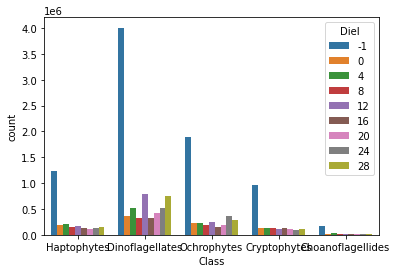

In [45]:
sns.barplot(x = "Class", y = "count", hue = "Diel", data=total_frame_class)

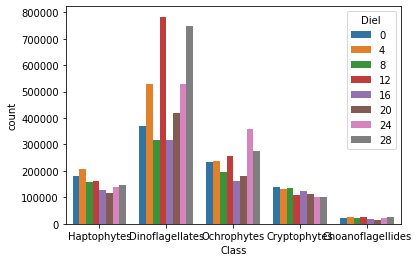

In [46]:
sns.barplot(x = "Class", y = "count", hue = "Diel", data=total_frame_class.loc[total_frame_class.Diel != -1])

In [34]:
combined = pd.concat([total_frame_class.loc[total_frame_class.Diel == -1], \
           total_frame_class.loc[total_frame_class.Diel != -1].groupby("Class", as_index = False).sum()], \
          axis = 0)
combined.Diel[combined.Diel == -1] = "merged"
combined.Diel[combined.Diel == 112] = "summed_indiv"
combined

<ipython-input-34-160e714bf00c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined.Diel[combined.Diel == -1] = "merged"
<ipython-input-34-160e714bf00c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined.Diel[combined.Diel == 112] = "summed_indiv"


,Class,count,Sample,Diel
0,Haptophytes,1243596,merged-estimated-taxonomy-parallel.out,merged
1,Dinoflagellates,4005937,merged-estimated-taxonomy-parallel.out,merged
2,Ochrophytes,1899135,merged-estimated-taxonomy-parallel.out,merged
3,Cryptophytes,959870,merged-estimated-taxonomy-parallel.out,merged
4,Choanoflagellides,175057,merged-estimated-taxonomy-parallel.out,merged
0,Choanoflagellides,174732,NaN,summed_indiv
1,Cryptophytes,959872,NaN,summed_indiv
2,Dinoflagellates,4005685,NaN,summed_indiv
3,Haptophytes,1243327,NaN,summed_indiv
4,Ochrophytes,1899302,NaN,summed_indiv


In [48]:
total_frame_class.loc[total_frame_class.Diel != -1].groupby("Class", as_index = False).sum()

,Class,count,Diel
0,Choanoflagellides,174732,112
1,Cryptophytes,959872,112
2,Dinoflagellates,4005685,112
3,Haptophytes,1243327,112
4,Ochrophytes,1899302,112


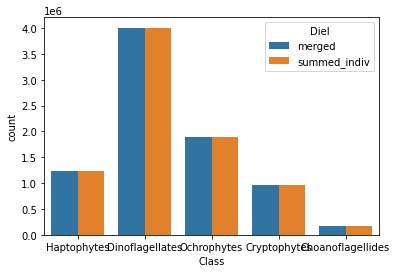

In [36]:
sns.barplot(x = "Class", y = "count", hue = "Diel", data=combined)